In [1]:
import pandas as pd
import os
from git import Repo
import matplotlib.pyplot as plt
import geopandas as gpd
import urllib
import shutil
%matplotlib inline

In [2]:
# your local folder into which you want to download the covid data
covidfolder = '../../data_external/covid19'

In [3]:
if os.path.isdir(covidfolder): # if repo exists, pull newest data
    repo = Repo(covidfolder)
    repo.remotes.origin.pull()
else: # otherwise, clone from remote
    repo = Repo.clone_from('https://github.com/CSSEGISandData/COVID-19.git',covidfolder)
datadir = repo.working_dir + '/csse_covid_19_data/csse_covid_19_daily_reports'

In [4]:
c = pd.read_csv(datadir+'/03-27-2020.csv')

In [5]:
c.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-03-27 22:14:55,34.223334,-82.461707,4,0,0,4,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-03-27 22:14:55,30.295065,-92.414197,8,1,0,7,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-03-27 22:14:55,37.767072,-75.632346,2,0,0,2,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-03-27 22:14:55,43.452658,-116.241552,54,0,0,54,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-03-27 22:14:55,41.330756,-94.471059,1,0,0,1,"Adair, Iowa, US"


In [6]:
# make a geometry object from Lat, Long
geo = gpd.points_from_xy(c['Long_'], c['Lat'])
# give the geometry to geopandas together with c
gc = gpd.GeoDataFrame(c, geometry=geo)
gc.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,geometry
0,45001.0,Abbeville,South Carolina,US,2020-03-27 22:14:55,34.223334,-82.461707,4,0,0,4,"Abbeville, South Carolina, US",POINT (-82.46171 34.22333)
1,22001.0,Acadia,Louisiana,US,2020-03-27 22:14:55,30.295065,-92.414197,8,1,0,7,"Acadia, Louisiana, US",POINT (-92.41420 30.29506)
2,51001.0,Accomack,Virginia,US,2020-03-27 22:14:55,37.767072,-75.632346,2,0,0,2,"Accomack, Virginia, US",POINT (-75.63235 37.76707)
3,16001.0,Ada,Idaho,US,2020-03-27 22:14:55,43.452658,-116.241552,54,0,0,54,"Ada, Idaho, US",POINT (-116.24155 43.45266)
4,19001.0,Adair,Iowa,US,2020-03-27 22:14:55,41.330756,-94.471059,1,0,0,1,"Adair, Iowa, US",POINT (-94.47106 41.33076)


C:\Users\saika\AppData\Local\Temp\ipykernel_1400\176702308.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


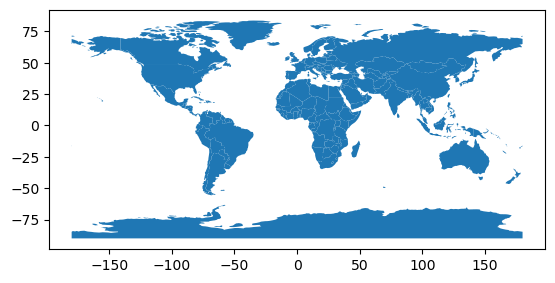

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot();

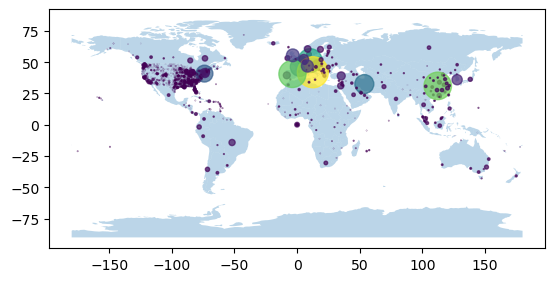

In [8]:
base = world.plot(alpha=0.3)
msz = 500 * gc['Confirmed'] / gc['Confirmed'].max()
gc.plot(ax=base, column='Confirmed', markersize=msz, alpha=0.7);

In [9]:
co = c[c['Province_State']=='Oregon']

In [10]:
# url of the data
census_url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip'

In [12]:
# location of your download
your_download_folder = '../../data_external'
if not os.path.isdir(your_download_folder):
    os.mkdir(your_download_folder)
us_county_file = your_download_folder + '/cb_2018_us_county_500k.zip'
# download if the file doesn't already exist
if not os.path.isfile(us_county_file):
    with urllib.request.urlopen(census_url) as response,open(us_county_file, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

In [13]:
us_counties = gpd.read_file(f"zip://{us_county_file}")
us_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


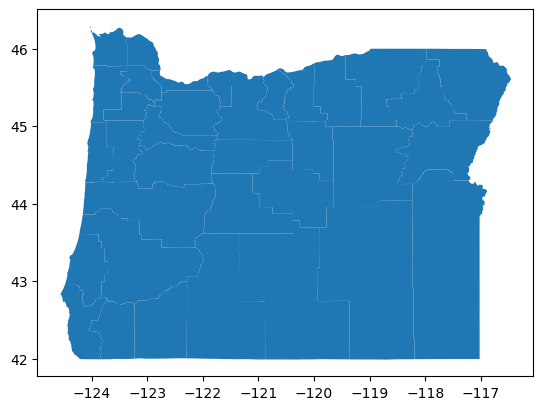

In [14]:
ore = us_counties[us_counties['STATEFP']=='41']
ore.plot();

In [15]:
ore = ore.astype({'GEOID': 'int64'}).rename(columns={'GEOID' : 'FIPS'})
co = co.astype({'FIPS': 'int64'})
orco = pd.merge(ore, co.iloc[:,:-1], on='FIPS')

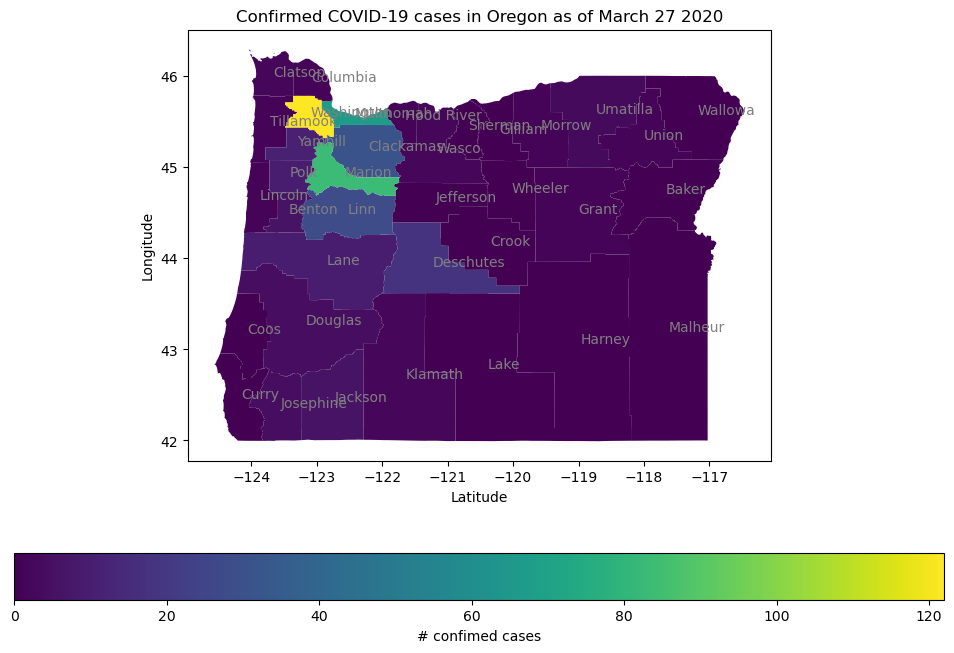

In [16]:
# plot coloring counties by number of confirmed cases
fig, ax = plt.subplots(figsize=(12, 8))
orco.plot(ax=ax, column='Confirmed', legend=True,
    legend_kwds={'label': '# confimed cases','orientation':'horizontal'})
# label the counties
for x, y, county in zip(orco['Long_'], orco['Lat'], orco['NAME']):
    ax.text(x, y, county, color='grey')
ax.set_title('Confirmed COVID-19 cases in Oregon as of March 27 2020')
ax.set_xlabel('Latitude'); ax.set_ylabel('Longitude');